In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.sparse import csr_matrix, hstack
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.preprocessing import LabelBinarizer

In [ ]:
##Load Data
data = pd.read_csv('C:\\Users\\Tejaswini\\Desktop\\Study Report\\mercari-price-suggestion-challenge\\train.tsv', sep = '\t')
data = data.sample(frac=0.1).reset_index(drop=True)

In [3]:
data.shape

(148254, 8)

In [4]:
org_data=data
org_data.shape

(148254, 8)

In [5]:
print(data.dtypes)

train_id               int64
name                  object
item_condition_id      int64
category_name         object
brand_name            object
price                float64
shipping               int64
item_description      object
dtype: object


# Data Wrangling

In [6]:
data=data.drop(['train_id'],axis = 1)
data.astype('object').describe().transpose()

,count,unique,top,freq
name,148254,137778,Bundle,241
item_condition_id,148254,5,1,64159
category_name,147640,1037,"Women/Athletic Apparel/Pants, Tights, Leggings",6198
brand_name,85253,2306,Nike,5466
price,148254,461,10,10014
shipping,148254,2,0,81980
item_description,148254,133706,No description yet,8381


Summary:
There are around 2k unique brands and majority of the items are Women's Brand.
Most of the items price is 10 dollars.
There are about 8k items with no descriptions

In [7]:
#number of missing values
data.isnull().sum()

name                     0
item_condition_id        0
category_name          614
brand_name           63001
price                    0
shipping                 0
item_description         0
dtype: int64

In [8]:
# function to impute missing values
def impute(data):
    data['category_name'].fillna(value = 'Other', inplace=True)
    data['brand_name'].fillna(value = 'Unknown', inplace=True)
    data['item_description'] = data['item_description'].fillna('None')
        
    return data

In [9]:
data = impute(data)
#data.isnull().sum()

name                 0
item_condition_id    0
category_name        0
brand_name           0
price                0
shipping             0
item_description     0
dtype: int64

# Exploratory Data Analysis

In [11]:
data.price.describe()

count    148254.000000
mean         26.655621
std          38.431921
min           0.000000
25%          10.000000
50%          17.000000
75%          29.000000
max        2000.000000
Name: price, dtype: float64

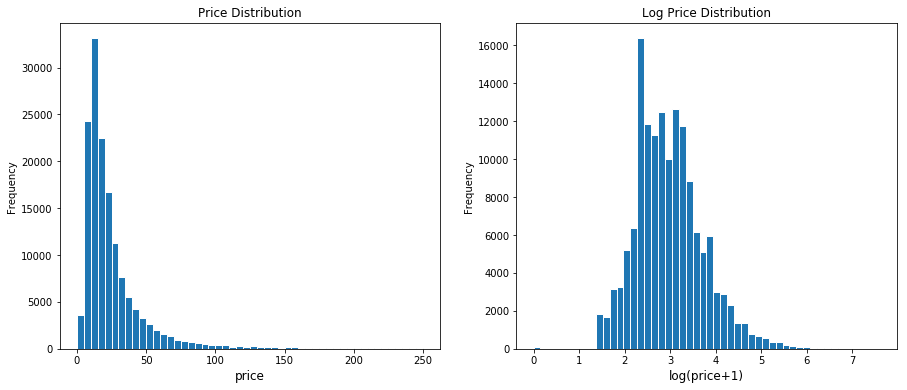

In [12]:
# Plot Price Distribution
plt.subplot(1, 2, 1)
(data['price']).plot.hist(bins=50, figsize=(15, 6), edgecolor = 'white', range = [0, 250])
plt.xlabel('price', fontsize=12)
plt.title('Price Distribution', fontsize=12)

#Plot Log Price Distribution
plt.subplot(1, 2, 2)
np.log(data['price']+1).plot.hist(bins=50, figsize=(15,6), edgecolor='white')
plt.xlabel('log(price+1)', fontsize=12)
plt.title('Log Price Distribution', fontsize=12)

plt.show()

In [13]:
##Remove items with price=0
data[data.price==0].count()

name                 80
item_condition_id    80
category_name        80
brand_name           80
price                80
shipping             80
item_description     80
dtype: int64

In [14]:
data[data.price==0].shape

(80, 7)

In [15]:
# Remove items with price of $0 from our training set
data = data[data.price != 0]
data.shape

(148174, 7)

 Shipping Distribution

In [16]:
data['shipping'].value_counts() / len(data)

0    0.552938
1    0.447062
Name: shipping, dtype: float64

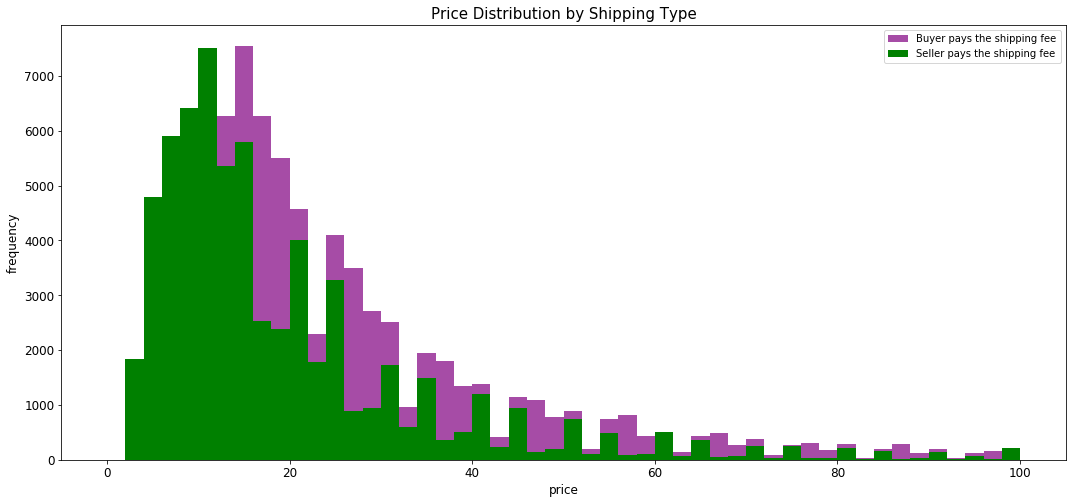

In [17]:
##Price Distribution by Shipping Type
shipping_buyer = data.loc[data['shipping'] == 0, 'price']
shipping_seller = data.loc[data['shipping'] == 1, 'price']

fig, ax = plt.subplots(figsize=(18,8))

ax.hist(shipping_buyer, color='purple', alpha=0.7, bins=50, range = [0, 100],label='Buyer pays the shipping fee')
ax.hist(shipping_seller, color='green', alpha=1.0, bins=50, range = [0, 100],label='Seller pays the shipping fee')
plt.xlabel('price', fontsize=12)
plt.ylabel('frequency', fontsize=12)
plt.title('Price Distribution by Shipping Type', fontsize=15)
plt.tick_params(labelsize=12)
plt.legend()
plt.show()

In [18]:
#avg price based on shipping type
print('Average price if buyer pays shipping is {}'.format(round(shipping_buyer.mean(), 2)))
print('Average price if seller pays shipping is {}'.format(round(shipping_seller.mean(), 2)));

Average price if buyer pays shipping is 30.04
Average price if seller pays shipping is 22.51


In [19]:
data['item_condition_id'].value_counts() / len(data)

1    0.432755
3    0.292501
2    0.251832
4    0.021434
5    0.001478
Name: item_condition_id, dtype: float64

In [20]:
data['item_condition_id'].astype('object').describe()

count     148174
unique         5
top            1
freq       64123
Name: item_condition_id, dtype: int64

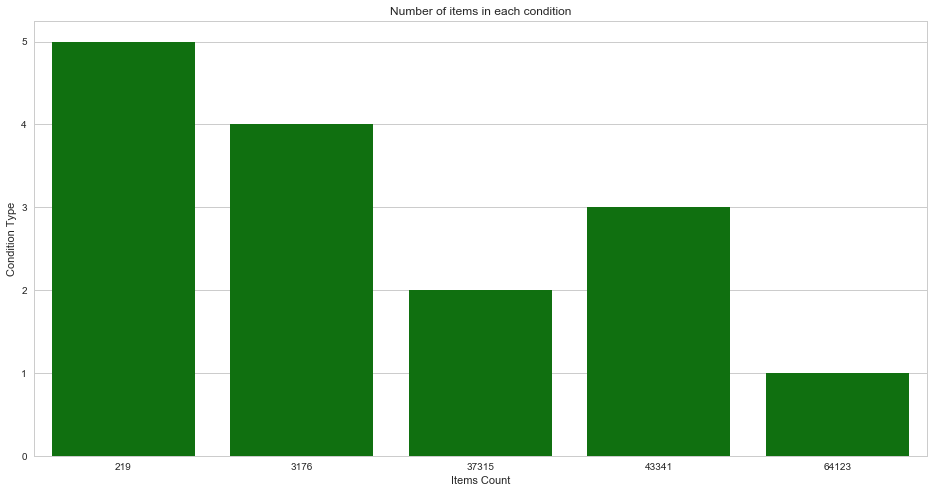

In [21]:
###distribution based on condition type of item
condition_info = data['item_condition_id'].value_counts().reset_index()

sns.set(style="whitegrid")

# Initialize the matplotlib fig
f, ax = plt.subplots(figsize=(16, 8))

# Plot total items per category
sns.set_color_codes("pastel")
sns.barplot(x="item_condition_id", y='index', data=condition_info,
            label="#Items", color="green")

# Add legend and informative axis label
ax.set( ylabel="Condition Type", title='Number of items in each condition',
       xlabel="Items Count")

plt.show()

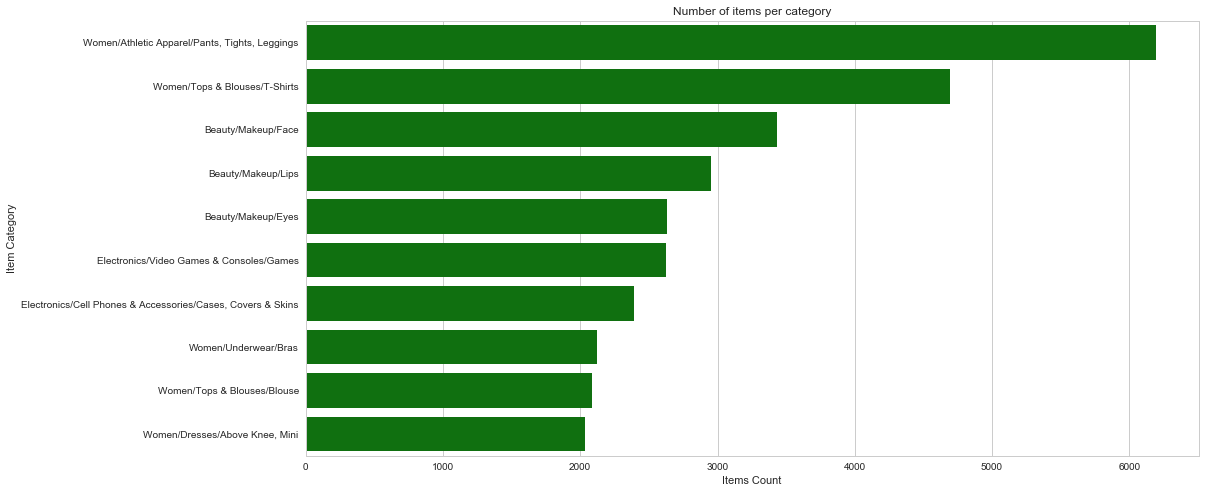

In [23]:
###Top 10 categories distribution
top_category = data['category_name'].value_counts()[:10].reset_index()

sns.set(style="whitegrid")

# Initialize the matplotlib figure
f, ax = plt.subplots(figsize=(16, 8))

# Plot the total items per category
sns.set_color_codes("pastel")
sns.barplot(x="category_name", y='index', data=top_category,
            label="# Items", color="green")

# Add a legend and informative axis label
ax.set( ylabel="Item Category", title='Number of items per category',
       xlabel="Items Count")

plt.rc('xtick',labelsize=25)
plt.rc('ytick',labelsize=25)

plt.show()

# Feature Engineering

In [24]:
# Function to create new Category Features
def transform_category_name(category_name):
    try:
        main, sub1, sub2= category_name.split('/')
        return main, sub1, sub2
    except:
        return 'Other','Other','Other'

In [25]:
data['main_category'], data['sub_category1'], data['sub_category2'] = zip(*data['category_name'].apply(transform_category_name))
cat_data = data[['main_category','sub_category1','sub_category2', 'price']]
cat_data.describe(include='all')

,main_category,sub_category1,sub_category2,price
count,148174,148174,148174,148174.000000
unique,10,113,724,NaN
top,Women,Athletic Apparel,"Pants, Tights, Leggings",NaN
freq,66644,13631,6195,NaN
mean,NaN,NaN,NaN,26.670013
std,NaN,NaN,NaN,38.437302
min,NaN,NaN,NaN,3.000000
25%,NaN,NaN,NaN,10.000000
50%,NaN,NaN,NaN,17.000000
75%,NaN,NaN,NaN,29.000000


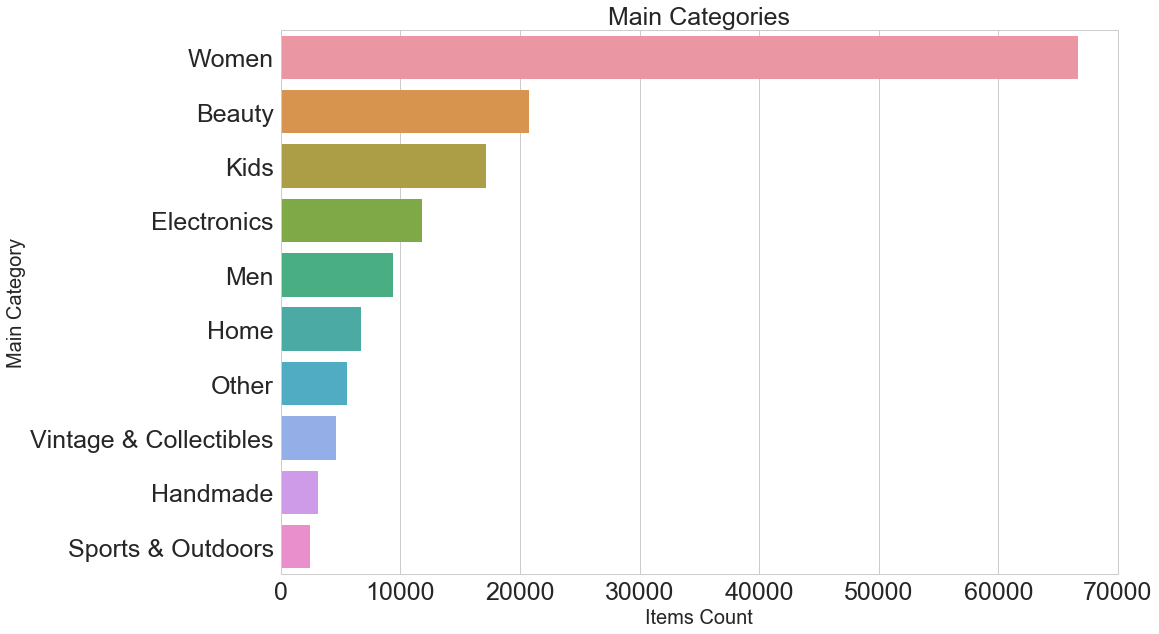

In [26]:
plt.figure(figsize=(15,10))
sns.countplot(y = data['main_category'], order = data['main_category'].value_counts().index, orient = 'v')
plt.title('Main Categories', fontsize = 25)
plt.ylabel('Main Category', fontsize = 20)
plt.xlabel('Items Count',  fontsize = 20)
plt.rc('xtick',labelsize=20)
plt.rc('ytick',labelsize=20)
plt.show()

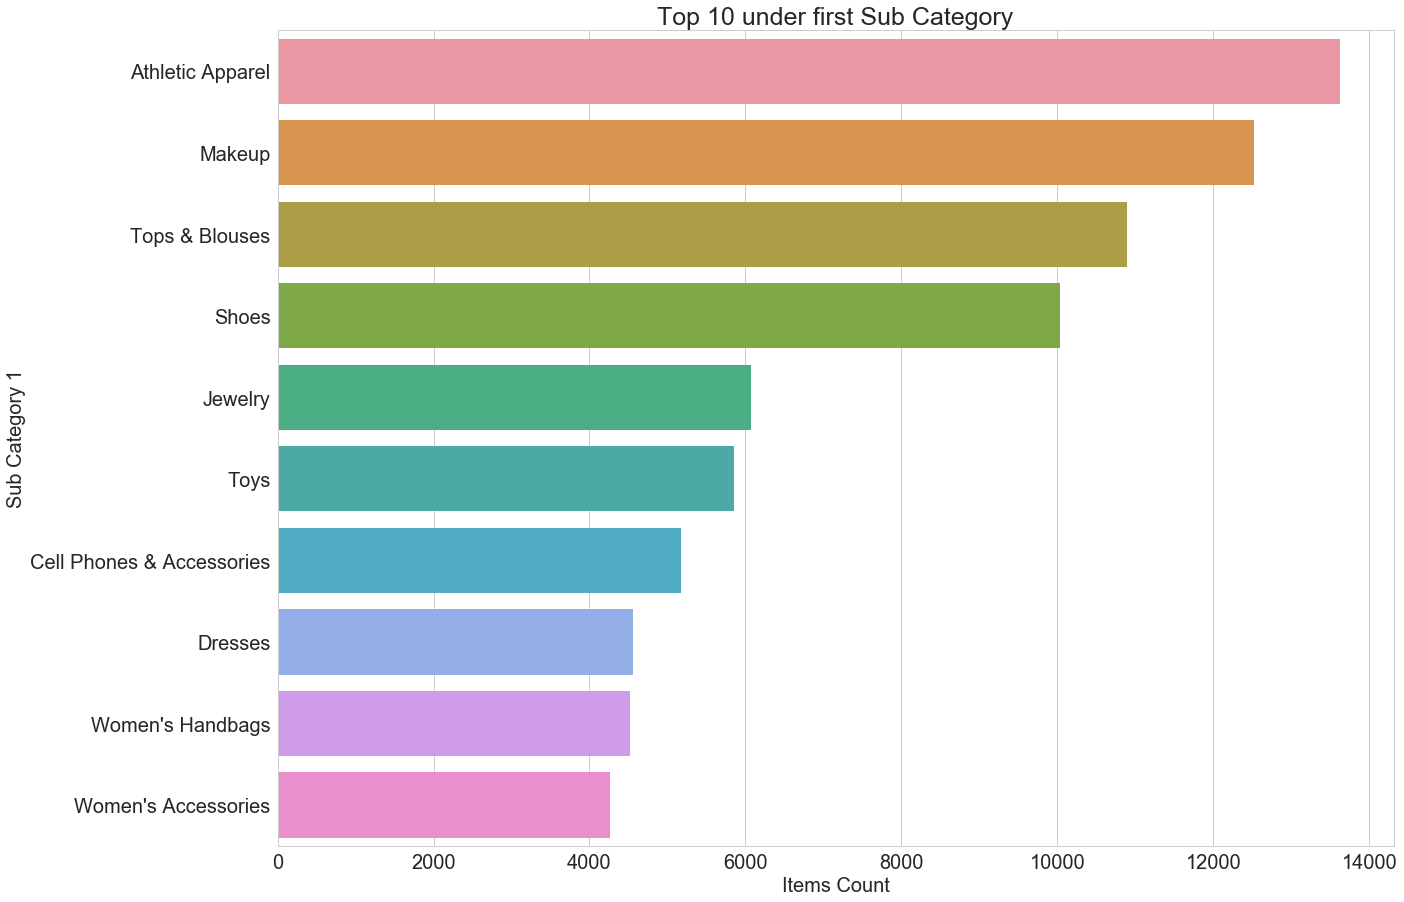

In [27]:
plt.figure(figsize=(20,15))
sns.countplot(y = cat_data['sub_category1'], order = cat_data['sub_category1'].value_counts().index[:10], orient = 'v')
plt.title('Top 10 under first Sub Category', fontsize = 25)
plt.ylabel('Sub Category 1', fontsize = 20)
plt.xlabel('Items Count',  fontsize = 20)
plt.rc('xtick',labelsize=25)
plt.rc('ytick',labelsize=25)
plt.show()

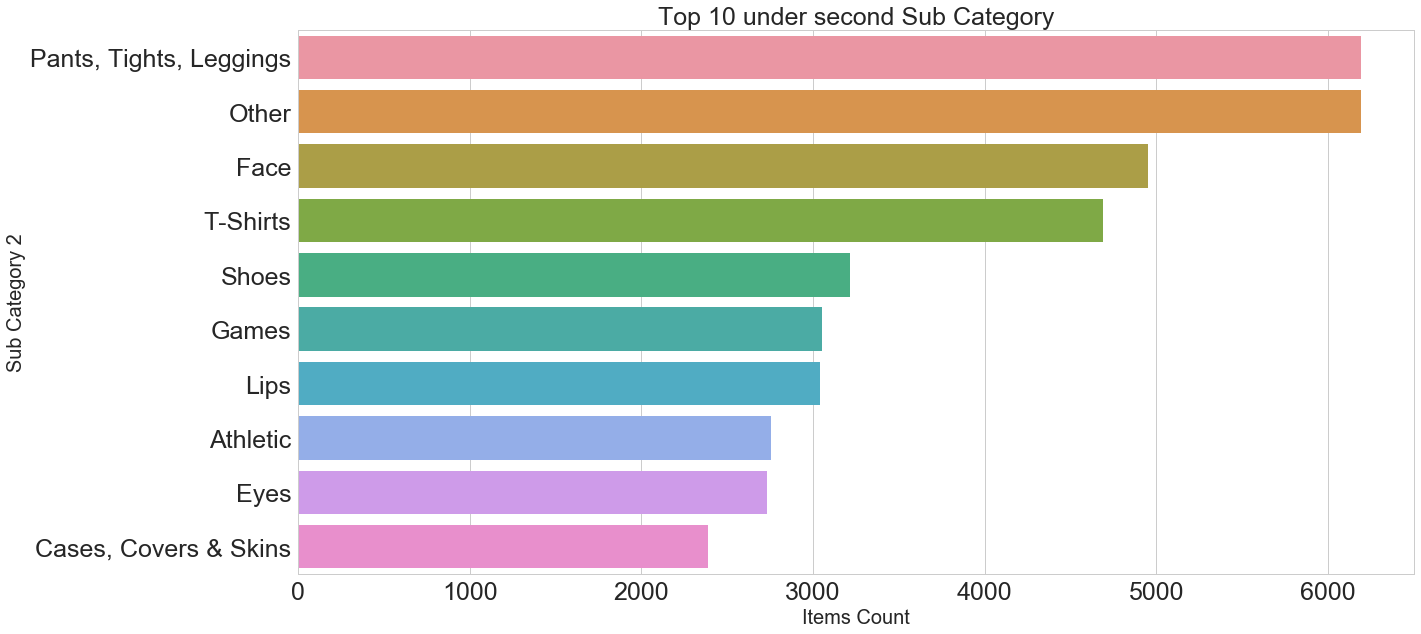

In [28]:
plt.figure(figsize=(20,10))
sns.countplot(y = cat_data['sub_category2'], order = cat_data['sub_category2'].value_counts().index[:10], orient = 'v')
plt.title('Top 10 under second Sub Category', fontsize = 25)
plt.ylabel('Sub Category 2', fontsize = 20)
plt.xlabel('Items Count',  fontsize = 20)
plt.rc('xtick',labelsize=25)
plt.rc('ytick',labelsize=25)
plt.show()

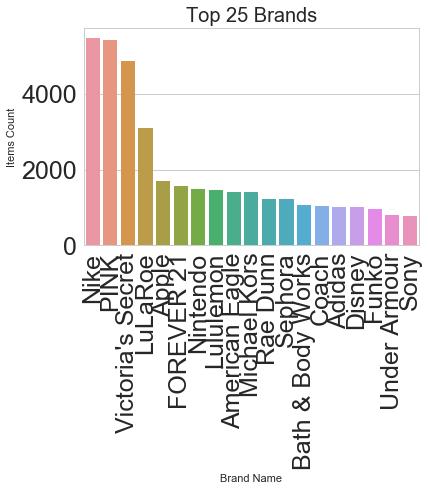

In [30]:
# Most popular Brands Distribution
popular_brands = data['brand_name'].value_counts()[1:20].reset_index().rename(columns={'index': 'Brand Name', 'brand_name':'Items Count'})
ax = sns.barplot(x="Brand Name", y="Items Count", data=popular_brands)
ax.set_xticklabels(ax.get_xticklabels(),rotation=90)
ax.set_title('Top 25 Brands', fontsize=20)
plt.rc('xtick',labelsize=25)
plt.rc('ytick',labelsize=25)
plt.show()

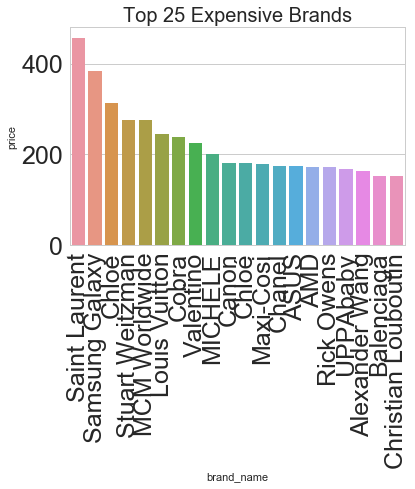

In [31]:
#Top Expensive Brands Distribution
top_expensive_brands = pd.DataFrame(data.groupby(['brand_name'],as_index=True).std().price.sort_values(ascending=False)[0:20]).reset_index()
ax = sns.barplot(x="brand_name", y="price", data=top_expensive_brands)
ax.set_xticklabels(ax.get_xticklabels(),rotation=90)
ax.set_title('Top 25 Expensive Brands', fontsize=20)
plt.show()

In [32]:
data.item_description = data.item_description.astype(str)
descr = data[['name','item_description', 'price']]
descr['count'] = descr['item_description'].apply(lambda x : len(str(x)))
descr.head()

C:\Users\Tejaswini\Anaconda3\lib\site-packages\ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  after removing the cwd from sys.path.


,name,item_description,price,count
0,Patagonia xs fleece pullover,♡ beautiful sherpa mint sweatshirt ♡ R1 fleece...,38.0,92
1,Blue Crush DVD,Movie in good condition. Plays perfectly.,5.0,41
2,Ultimate San Diego Chargers bundle,In great condition Flip flops size 7/8 Long sl...,30.0,138
3,Sylvania Portable Bluetooth Speaker,New in box.,12.0,11
4,Jewelry Lot 12LBS,No description yet,40.0,18


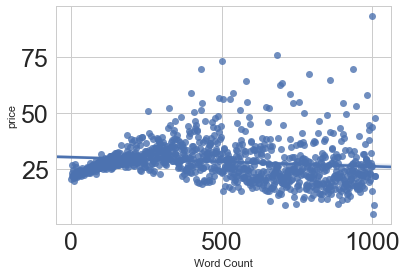

In [33]:
##Plot price distribution
df = descr.groupby('count')['price'].mean().reset_index()
sns.regplot(x=df["count"], y=(df["price"]))
plt.xlabel("Word Count")
plt.show()

# Text Preprocessing

In [44]:
###function to normalize words
import string
from nltk.corpus import stopwords
stopwords=stopwords.words('english')
# function to remove punctuations
def remove_punctuation(sentence: str) -> str:
    return sentence.translate(str.maketrans('', '', string.punctuation))

# function to remove stop words
def remove_stop_words(x):
    x = ' '.join([i for i in x.lower().split(' ') if i not in stopwords])
    return x

# function to lowercase the words
def to_lower(x):
    return x.lower()

In [45]:
###Normalize words
# Stem the Words
from nltk.stem.porter import PorterStemmer
porter = PorterStemmer()
data['item_description'] = data['item_description'].apply(porter.stem)
data['item_description'] = data['item_description'].apply(remove_punctuation)
data['item_description'] = data['item_description'].apply(remove_stop_words)
data['item_description'] = data['item_description'].apply(to_lower)
data['name'] = data['name'].apply(remove_punctuation)
data['name'] = data['name'].apply(remove_stop_words)
data['name'] = data['name'].apply(to_lower)

In [46]:
# Examine the normalize item description
data['item_description'].head()

0    ♡ beautiful sherpa mint sweatshirt ♡ r1 fleece...
1                 movie good condition plays perfectli
2    great condition flip flops size 78 long sleeve...
3                                              new box
4                                      description yet
Name: item_description, dtype: object

In [47]:
##Normalizing price
data['price']=np.log1p(data['price'])

In [48]:
data.shape

(148174, 10)

# Encoding Categorical Features

In [49]:
data.item_description = data.item_description.astype('category')
data.name = data.name.astype('category')
data.brand_name = data.brand_name.astype('category')

In [50]:
data.main_category = data.main_category.astype('category')
data.sub_category1 = data.sub_category1.astype('category')
data.sub_category2 = data.sub_category2.astype('category')

In [51]:
print("Encoding Name feature")
count = CountVectorizer()
X_name = count.fit_transform(data["name"])

Encoding Name feature


In [52]:
print("Encoding Category features")
#unique_categories = pd.Series("/".join(df["category_name"].unique().astype("str")).split("/")).unique()
#count_mcategory = CountVectorizer()
X_mcategory = count.fit_transform(data["main_category"])
X_subcategory1 = count.fit_transform(data["sub_category1"])
X_subcategory2 = count.fit_transform(data["sub_category2"])

Encoding Category features


In [53]:
print("Encoding Item Description using TfIdf Vectorizer")
tfidfVect = TfidfVectorizer(ngram_range = (1,2),stop_words = "english")
X_descp = tfidfVect.fit_transform(data["item_description"])

Encoding Item Description using TfIdf Vectorizer


In [54]:
print("Encoding Brand name using Label Binarizer")
vect_brand = LabelBinarizer(sparse_output=True)
X_brand = vect_brand.fit_transform(data["brand_name"])

Encoding Brand name using Label Binarizer


In [55]:
import scipy
print("Dummy Encoders")
X_dummies = scipy.sparse.csr_matrix(pd.get_dummies(data[[
    "item_condition_id", "shipping"]], sparse = True).values)

X = scipy.sparse.hstack((X_dummies, 
                         X_descp,
                         X_brand,
                         X_mcategory,X_subcategory1,X_subcategory2,
                         X_name)).tocsr()

Dummy Encoders


In [56]:
y=data['price']
X.shape

(148174, 972986)

In [57]:
X_train = X[:118538]
X_train.shape

(118538, 972986)

In [58]:
y_train = data['price'][:118538]
y_train.shape

(118538,)

# Model Building

In [59]:
###Ridge Regression Model 
from sklearn.linear_model import Ridge
ridge_reg = Ridge(alpha = 1.0,solver = "lsqr", fit_intercept=False)
ridge_reg.fit(X_train, y_train)
ridge_reg.score(X_train,y_train)

0.7627834746354991

In [61]:
X_test = X[118538:]
X_test.shape

(29636, 972986)

In [62]:
y_test = data['price'][118538:]
y_test.shape

(29636,)

In [67]:
###Compute Root Mean Squared Log Error
from sklearn.metrics import mean_squared_log_error
from sklearn.metrics import mean_squared_error
ridge_y_pred = ridge_reg.predict(X_test)
# print(ridge_reg.score(X_test,y_test))
print("RMSLE Score:"+ str(np.sqrt(mean_squared_log_error(y_test,ridge_y_pred))))

RMSLE Score:0.12559796087255815


In [71]:
### Lasso Regression Model
from sklearn.linear_model import Lasso
lasso = Lasso(alpha = 1.0, fit_intercept=True)
lasso.fit(X_train, y_train)

Lasso(alpha=1.0, copy_X=True, fit_intercept=True, max_iter=1000,
   normalize=False, positive=False, precompute=False, random_state=None,
   selection='cyclic', tol=0.0001, warm_start=False)

In [70]:
###Compute Root Mean Squared Log Error
lasso_y_pred = lasso.predict(X_test)
print("RMSLE Score:"+ str(np.sqrt(mean_squared_log_error(y_test,lasso_y_pred))))

RMSLE Score:0.18553839249474663


In [ ]:
### Random Forest Regression Model 
from sklearn.ensemble import RandomForestRegressor
m = RandomForestRegressor(n_jobs=-1,min_samples_leaf=3,n_estimators=200)
m.fit(X_train, y_train)
#m.score(X_train,y_train)

In [249]:
###Compute Root Mean Squared Log Error
from sklearn.metrics import mean_squared_log_error
from sklearn.metrics import mean_squared_error
rf_pred_y = m.predict(X_test)
print(np.sqrt(mean_squared_log_error(y_test,rf_pred_y)))

0.40575710940604515
0.06023980675281751
